##### Start

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from phi.torch.flow import *
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
class LocalPlanner(nn.Module):
    """
    Local Planner Module for Collision Avoidance Navigation.
    
    This model takes as input:
      - lidar_dists: a tensor of shape (B, 360) containing LiDAR distance readings 
                     where each index corresponds to a reading at each degree.
      - world_theta: a tensor of shape (B,) representing the robot's world orientation 
                     in radians.
                     
    The world_theta is converted into its sine and cosine components and concatenated with 
    the lidar distances to form a feature vector of size 362.
    
    The model predicts actions as a tensor of shape (B, 2):
       - The first component (L) is in the range (0, 1) (via a sigmoid activation) and 
         represents a normalized forward movement.
       - The second component (theta) is in the range (-1, 1) (via a tanh activation) and, 
         when multiplied by π, yields an angle in (-π, π) for steering.
    """
    
    def __init__(self, input_dim=362, hidden_dims=[512, 256, 128, 64]):
        super(LocalPlanner, self).__init__()
        
        # Build a feature extractor (backbone)
        layers = []
        prev_dim = input_dim
        for hidden in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden))
            layers.append(nn.ReLU())
            prev_dim = hidden
        self.backbone = nn.Sequential(*layers)
        
        # Define head for predicting linear movement (L) in (0,1)
        self.linear_head = nn.Sequential(
            nn.Linear(prev_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()  # restricts output to (0,1)
        )
        
        # Define head for predicting angular movement (θ) in (-1,1)
        self.angular_head = nn.Sequential(
            nn.Linear(prev_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Tanh()     # restricts output to (-1,1)
        )
    
    def forward(self, lidar_dists, world_theta):
        """
        Forward pass for the local planner.
        
        Args:
            lidar_dists (torch.Tensor): Tensor of shape (B, 360), where each entry represents 
                                        a LiDAR distance at that degree.
            world_theta (torch.Tensor): Tensor of shape (B,) representing the robot's world orientation 
                                        in radians.
                                        
        Returns:
            torch.Tensor: Tensor of shape (B, 2) representing the predicted action:
                          - action[:, 0] is the normalized linear displacement L in (0,1).
                          - action[:, 1] is the normalized angular value in (-1,1).
                            (Multiplying this by π will yield an angle in (-π, π).)
        """
        # Ensure world_theta has shape (B,1) for concatenation.
        if world_theta.dim() == 1:
            world_theta = world_theta.unsqueeze(1)
        
        # Convert world_theta to its sine and cosine representation.
        sin_theta = torch.sin(world_theta)
        cos_theta = torch.cos(world_theta)
        
        # Concatenate the 360-D lidar_dists with the 2-D [sin_theta, cos_theta] → (B, 362)
        x = torch.cat([lidar_dists, sin_theta, cos_theta], dim=1)
        
        # Extract common features with the backbone.
        features = self.backbone(x)
        
        # Get the predicted actions.
        L = self.linear_head(features).squeeze(-1)     # shape: (B,)
        theta = self.angular_head(features).squeeze(-1)  # shape: (B,)
        
        # The predicted theta is in (-1,1).
        # When multiplied by π externally, this will yield an angle in (-π, π).
        action = torch.stack([L, theta], dim=1)
        return action

# Example usage:
if __name__ == "__main__":
    # Generate dummy inputs (batch size 4)
    dummy_lidar = torch.rand(4, 360)         # Simulated LiDAR distances
    dummy_world_theta = torch.rand(4) * 2 * 3.1416  # Simulated world theta in radians

    # Instantiate the local planner model.
    model = LocalPlanner()
    model.eval()
    
    with torch.no_grad():
        predicted_action = model(dummy_lidar, dummy_world_theta)
        print("Predicted actions (L, theta):\n", predicted_action)

Predicted actions (L, theta):
 tensor([[ 0.5202, -0.0158],
        [ 0.5204, -0.0161],
        [ 0.5203, -0.0157],
        [ 0.5204, -0.0158]])


In [4]:
def plot_agent_behavior(binary_img, sensor, world_theta, action, lidar_dists, world_limits):
    """
    Plot the agent on the input binary map.
    
    Args:
      binary_img (np.array): The binary environment image.
      sensor (np.array): 2D world coordinate of sensor position.
      world_theta (float): Sensor's world orientation (radians).
      action (tuple): The predicted action (L, theta_pred_norm).
      lidar_dists (np.array): LiDAR distances (360,).
      world_limits (np.array): [[min_x, max_x], [min_y, max_y]].
    """
    import numpy as np
    import torch
    import torch.nn.functional as F
    import matplotlib.pyplot as plt

    # Compute predicted heading.
    L, theta_pred_norm = action
    pred_heading = (world_theta + theta_pred_norm * np.pi) % (2 * np.pi)
    
    # Compute best clearance heading (for visualization) using softmax:
    temperature = 0.5
    lidar_dists_t = torch.tensor(lidar_dists, dtype=torch.float32)
    # Use numpy's linspace (with endpoint=False) and convert to torch tensor:
    ray_angles = torch.tensor(np.linspace(0, 2 * np.pi, len(lidar_dists), endpoint=False),
                              dtype=torch.float32)
    best_weights = F.softmax(lidar_dists_t / temperature, dim=0)
    best_heading = torch.sum(best_weights * ray_angles).item()
    
    # Calculate image scaling factors.
    height, width = binary_img.shape
    world_width = world_limits[0][1] - world_limits[0][0]
    world_height = world_limits[1][1] - world_limits[1][0]
    scale_x = width / world_width
    scale_y = height / world_height

    # Convert sensor position to image coordinates.
    sensor_img_x = int(np.rint((sensor[0] - world_limits[0][0]) * scale_x))
    sensor_img_y = height - int(np.rint((sensor[1] - world_limits[1][0]) * scale_y))
    
    fig, ax = plt.subplots(figsize=(8,8))
    ax.imshow(binary_img, cmap='gray', origin='upper')
    
    # Plot sensor position.
    ax.plot(sensor_img_x, sensor_img_y, 'go', markersize=10, label='Sensor')
    
    # Define a scaling factor for arrow length (for visualization).
    arrow_scale = 50
    
    # Compute end points for predicted heading arrow.
    end_x_pred = sensor_img_x + arrow_scale * np.cos(pred_heading)
    end_y_pred = sensor_img_y - arrow_scale * np.sin(pred_heading)
    ax.arrow(sensor_img_x, sensor_img_y, end_x_pred - sensor_img_x,
             end_y_pred - sensor_img_y, head_width=5, head_length=10, fc='r', ec='r', label='Predicted Heading')
    
    # Compute end points for best clearance heading arrow.
    end_x_best = sensor_img_x + arrow_scale * np.cos(best_heading)
    end_y_best = sensor_img_y - arrow_scale * np.sin(best_heading)
    ax.arrow(sensor_img_x, sensor_img_y, end_x_best - sensor_img_x,
             end_y_best - sensor_img_y, head_width=5, head_length=10, fc='g', ec='g', label='Best Clearance Heading')
    
    ax.legend()
    ax.set_title("Agent Behavior on Environment Map")
    plt.show()

Epoch 0/2000 | Loss: 0.0093 | Mean L: 0.4346 | Mean d_pred: 1.8040 | Mean angle_err (rad): 1.5426
Epoch 100/2000 | Loss: -0.9801 | Mean L: 0.8569 | Mean d_pred: 1.8195 | Mean angle_err (rad): 1.2911
Epoch 200/2000 | Loss: -1.1824 | Mean L: 0.7898 | Mean d_pred: 1.9941 | Mean angle_err (rad): 1.2905
Epoch 300/2000 | Loss: -1.0462 | Mean L: 0.8057 | Mean d_pred: 1.8671 | Mean angle_err (rad): 1.3412
Epoch 400/2000 | Loss: -1.2717 | Mean L: 0.8125 | Mean d_pred: 2.0534 | Mean angle_err (rad): 1.2713
Epoch 500/2000 | Loss: -1.2007 | Mean L: 0.7575 | Mean d_pred: 1.9615 | Mean angle_err (rad): 1.1847
Epoch 600/2000 | Loss: -1.2485 | Mean L: 0.7598 | Mean d_pred: 1.9785 | Mean angle_err (rad): 1.2277
Epoch 700/2000 | Loss: -1.1107 | Mean L: 0.7018 | Mean d_pred: 1.8516 | Mean angle_err (rad): 1.2349
Epoch 800/2000 | Loss: -1.3307 | Mean L: 0.8357 | Mean d_pred: 2.1022 | Mean angle_err (rad): 1.3296
Epoch 900/2000 | Loss: -1.0147 | Mean L: 0.8646 | Mean d_pred: 1.8849 | Mean angle_err (rad): 

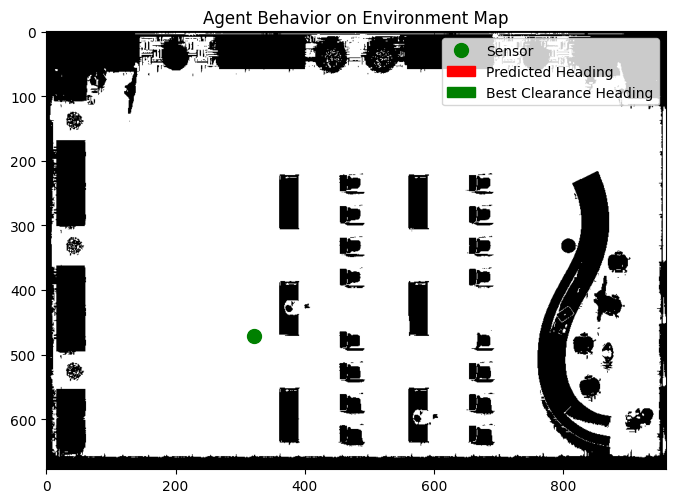

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Assume LocalPlanner is already defined above, for example:
# class LocalPlanner(nn.Module):
#    def __init__(self, ...):
#       ...
#    def forward(self, lidar_dists, world_theta):
#       ...

# --- Revised training function with a lower angular penalty weight (gamma) ---
def train_local_planner(num_epochs=2000, batch_size=64, lr=1e-3, safe_distance=1.0,
                        alpha=2.0, sigma=0.2, gamma=0.2, temperature=0.5):
    """
    Train the LocalPlanner model using a predictive modeling approach that leverages LiDAR data 
    to minimize collision risk.
    
    The reward is defined as:
         R = L - alpha * L * ReLU(safe_distance - d_pred) - gamma * (angle_error)^2
    where:
      - L is the predicted normalized forward speed.
      - d_pred is the weighted (Gaussian) clearance estimate along the predicted heading.
      - angle_error is the (wrapped) difference between the predicted absolute heading and
        the best clearance heading computed via softmax over LiDAR distances.
    
    By minimizing the negative average reward, the model is encouraged to move forward when
    clearance is good, and steer toward directions of higher clearance.
    
    Note: We have reduced gamma to 0.2 in this version to avoid the degenerate solution where
    L is driven to 0.
    
    Args:
        num_epochs (int): Number of epochs.
        batch_size (int): Batch size.
        lr (float): Learning rate.
        safe_distance (float): Desired minimum safe distance.
        alpha (float): Scaling factor for forward penalty.
        sigma (float): Standard deviation for Gaussian weighting of LiDAR rays.
        gamma (float): Weight for angular deviation penalty.
        temperature (float): Temperature for softmax to compute best clearance heading.
    
    Returns:
        model (LocalPlanner): The trained model.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LocalPlanner().to(device)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Load the input binary map from file.
    # (Assuming create_binary_image is defined to load an image and process it to binary.)
    from LiDAR_Fast import create_binary_image, get_lidar_points
    binary_img = create_binary_image(image_path=r"F:\Aerosim-Simulation-Zone\Try\New_WR_World.png")
    
    # World limits: Assume the world spans ~ x: [-10,10] and y: [-8,8].
    world_limits = np.array([[-10, 10], [-8, 8]])
    num_rays = 360
    
    # Pre-compute the ray angles.
    angles_np = np.linspace(0, 2 * np.pi, num_rays, endpoint=False)
    ray_angles = torch.tensor(angles_np, dtype=torch.float32, device=device)  # Shape: (360,)
    
    for epoch in range(num_epochs):
        # --- Sample a batch of sensor positions and orientations ---
        sensors_np = np.random.uniform(low=[world_limits[0, 0], world_limits[1, 0]],
                                       high=[world_limits[0, 1], world_limits[1, 1]],
                                       size=(batch_size, 2))
        world_thetas_np = np.random.uniform(low=-np.pi, high=np.pi, size=(batch_size,))
        
        # --- Compute the LiDAR scans ---
        # get_lidar_points returns (contact_points, lidar_dists); we only use lidar_dists.
        _, lidar_dists_np = get_lidar_points(binary_img, sensors_np, world_limits,
                                             num_rays=num_rays, max_range=4.0)
        lidar_dists = torch.tensor(lidar_dists_np, dtype=torch.float32, device=device)
        # Replace np.inf with max_range.
        max_range_val = 4.0
        lidar_dists = torch.clamp(lidar_dists, max=max_range_val)
        
        # Convert world orientations to tensor.
        world_thetas = torch.tensor(world_thetas_np, dtype=torch.float32, device=device)
        
        # --- Forward pass through the model ---
        actions = model(lidar_dists, world_thetas)  # (B, 2)
        L = actions[:, 0]                # Normalized forward speed (0,1)
        theta_pred_norm = actions[:, 1]    # Normalized angular adjustment (-1,1)
        
        # Predicted absolute heading = world_theta + (theta_pred_norm * pi)
        abs_angles = (world_thetas + theta_pred_norm * np.pi) % (2 * np.pi)  # (B,)
        
        # --- Compute clearance along predicted heading (d_pred) ---
        abs_angles_exp = abs_angles.unsqueeze(1)  # (B,1)
        diff = ray_angles.unsqueeze(0) - abs_angles_exp  # (B,360)
        diff = (diff + np.pi) % (2 * np.pi) - np.pi  # Wrap differences to (-pi,pi)
        # Gaussian weights centered on predicted heading.
        weights = torch.exp(-0.5 * (diff / sigma)**2)  # (B,360)
        weights = weights / (weights.sum(dim=1, keepdim=True) + 1e-6)
        d_pred = torch.sum(weights * lidar_dists, dim=1)  # (B,)
        
        # --- Compute best clearance heading (via softmax) ---
        best_weights = F.softmax(lidar_dists / temperature, dim=1)  # (B,360)
        best_heading = torch.sum(best_weights * ray_angles.unsqueeze(0), dim=1)  # (B,)
        
        # Angular error = difference between predicted heading and best clearance heading.
        angle_error = (abs_angles - best_heading + np.pi) % (2 * np.pi) - np.pi  # (B,)
        
        # --- Compute reward and loss ---
        # When clearance is below safe_distance, we incur a penalty on L.
        penalty_forward = F.tanh(safe_distance - d_pred)
        # Total reward.
        reward = L - alpha * L * penalty_forward - gamma * (angle_error ** 2)
        loss = -reward.mean()  # We maximize reward by minimizing negative reward.
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{num_epochs} | Loss: {loss.item():.4f} | "
                  f"Mean L: {L.mean().item():.4f} | Mean d_pred: {d_pred.mean().item():.4f} | "
                  f"Mean angle_err (rad): {angle_error.abs().mean().item():.4f}")
    
    return model

# --- Example usage ---
if __name__ == "__main__":
    # Train the model with updated hyperparameters.
    trained_model = train_local_planner(num_epochs=2000, batch_size=128, lr=1e-3,
                                          safe_distance=1.0, alpha=2.0, sigma=0.2,
                                          gamma=0.2, temperature=0.5)
    
    # trained_model = torch.load(r"F:\Aerosim-Simulation-Zone\Try\test_local_planner.pth", weights_only=False)

    trained_model.eval()
    
    # Determine device from the trained model.
    device = next(trained_model.parameters()).device

    # Get one sample to visualize behavior.
    from LiDAR_Fast import create_binary_image, get_lidar_points
    binary_img = create_binary_image(image_path=r"F:\Aerosim-Simulation-Zone\Try\New_WR_World.png")
    world_limits = np.array([[-10, 10], [-8, 8]])
    
    # Sample a single sensor position and orientation.
    sensor = np.random.uniform(low=[world_limits[0, 0], world_limits[1, 0]],
                               high=[world_limits[0, 1], world_limits[1, 1]], size=(2,))
    world_theta = np.random.uniform(low=-np.pi, high=np.pi)
    
    # Compute LiDAR data for the sensor.
    # For a single sensor input, get_lidar_points returns a 1D array of shape (360,).
    _, lidar_dists_np = get_lidar_points(binary_img, sensor, world_limits,
                                         num_rays=360, max_range=4.0)
    
    # Ensure the sensor tensor has the correct shape: (1, 360)
    sensor_tensor = torch.tensor(lidar_dists_np, dtype=torch.float32).reshape(1, -1)
    # Convert world_theta to a tensor of shape (1,)
    world_theta_tensor = torch.tensor([world_theta], dtype=torch.float32)
    
    # Move input tensors to the same device as the model.
    sensor_tensor = sensor_tensor.to(device)
    world_theta_tensor = world_theta_tensor.to(device)
    
    # (Optional) Print the shapes to confirm.
    print("sensor_tensor shape:", sensor_tensor.shape)        # Expected: (1, 360)
    print("world_theta_tensor shape:", world_theta_tensor.shape)  # Expected: (1,)
    
    # Compute predicted action.
    with torch.no_grad():
        action = trained_model(sensor_tensor, world_theta_tensor)
    action = action.squeeze(0).cpu().numpy()  # (L, theta_pred_norm)
    
    print("Sample sensor position:", sensor)
    print("World theta (rad):", world_theta)
    print("Predicted action (L, theta_pred_norm):", action)
    
    # Plot the agent behavior on the binary map.
    plot_agent_behavior(binary_img, sensor, world_theta, action, lidar_dists_np, world_limits)

In [6]:
torch.save(trained_model, "test_local_planner.pth")

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
# from LiDAR_Fast import create_binary_image, get_lidar_points
from LiDAR_Fast import *

# (Assume LocalPlanner definition exists above)

def train_local_planner(num_epochs=5000, batch_size=64, lr=1e-3, safe_distance=1.0,
                        alpha=2.0, sigma=0.2, gamma=1.0, temperature=0.5):
    """
    Train the LocalPlanner model using a predictive modeling approach that leverages LiDAR data 
    to minimize collision risk.

    In addition to the original reward:
         reward = L - alpha * L * ReLU(safe_distance - d_pred)
    where:
      - L is the predicted forward speed,
      - d_pred is the clearance along the predicted heading,
      - safe_distance is the minimum allowable distance,
      - alpha penalizes high speed in low-clearance areas,
    
    we now add an angular penalty. We compute a differentiable best clearance heading using a softmax 
    over the LiDAR distances and penalize the squared difference between this best heading and the 
    predicted absolute heading.
    
    The overall reward becomes:
         R = L - alpha * L * ReLU(safe_distance - d_pred) - gamma * (angle_error)^2

    We then minimize the negative average reward as a loss.

    Args:
        num_epochs (int): Number of training iterations.
        batch_size (int): Batch size for training.
        lr (float): Learning rate.
        safe_distance (float): Desired safe clearance.
        alpha (float): Penalty factor for unsafe forward speed.
        sigma (float): Standard deviation for Gaussian weighting (soft look-ahead).
        gamma (float): Weight for the angular deviation penalty.
        temperature (float): Temperature parameter for softmax to compute best clearance heading.
    
    Returns:
        model (LocalPlanner): The trained model.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LocalPlanner().to(device)
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Create a synthetic binary map for the environment.
    binary_img = create_binary_image(image_path=r"F:\Aerosim-Simulation-Zone\Try\New_WR_World.png")
    # World limits: assume environment spans from -10 to 10 on both X and Y.
    world_limits = np.array([[-10, 10], [-8, 8]])
    num_rays = 360
    
    # Precompute LiDAR ray angles (in radians).
    angles_np = np.linspace(0, 2 * np.pi, num_rays, endpoint=False)
    ray_angles = torch.tensor(angles_np, dtype=torch.float32, device=device)  # Shape: (360,)
    
    for epoch in range(num_epochs):
        # --- Sample a batch of sensor positions and orientations ---
        sensors_np = np.random.uniform(low=[world_limits[0, 0], world_limits[1, 0]],
                                       high=[world_limits[0, 1], world_limits[1, 1]],
                                       size=(batch_size, 2))
        world_thetas_np = np.random.uniform(low=-np.pi, high=np.pi, size=(batch_size,))
        
        # --- Compute the LiDAR scans ---
        # Use the fast LiDAR function; we only require lidar_dists.
        _, lidar_dists_np = get_lidar_points(binary_img, sensors_np, world_limits,
                                             num_rays=num_rays, max_range=4.0)
        lidar_dists = torch.tensor(lidar_dists_np, dtype=torch.float32, device=device)
        # Replace any np.inf with max_range (here, 4.0).
        max_range_val = 4.0
        lidar_dists = torch.clamp(lidar_dists, max=max_range_val)
        
        # Convert world orientations to a tensor.
        world_thetas = torch.tensor(world_thetas_np, dtype=torch.float32, device=device)
        
        # --- Forward pass through the Local Planner ---
        actions = model(lidar_dists, world_thetas)  # Output shape: (B, 2)
        L = actions[:, 0]                    # Normalized forward speed ∈ (0,1)
        theta_pred_norm = actions[:, 1]        # Normalized angle adjustment in (-1, 1)
        
        # Compute predicted absolute heading.
        abs_angles = (world_thetas + theta_pred_norm * np.pi) % (2 * np.pi)  # Shape: (B,)
        
        # --- Compute differentiable clearance estimate along predicted heading ---
        abs_angles_exp = abs_angles.unsqueeze(1)  # (B, 1)
        diff = ray_angles.unsqueeze(0) - abs_angles_exp  # (B, 360)
        diff = (diff + np.pi) % (2 * np.pi) - np.pi  # Wrap difference to (-π, π)
        
        # Gaussian weights for a smooth look-ahead.
        weights = torch.exp(-0.5 * (diff / sigma) ** 2)  # (B, 360)
        weights = weights / (weights.sum(dim=1, keepdim=True) + 1e-6)
        d_pred = torch.sum(weights * lidar_dists, dim=1)  # (B,)
        
        # --- Compute the best clearance heading via a differentiable softmax ---
        # Higher LiDAR reading means higher clearance. Using a temperature-controlled softmax.
        best_weights = F.softmax(lidar_dists / temperature, dim=1)  # (B, 360)
        best_heading = torch.sum(best_weights * ray_angles.unsqueeze(0), dim=1)  # (B,)
        
        # Compute the angular difference between the predicted heading and best clearance heading.
        angle_error = (abs_angles - best_heading + np.pi) % (2 * np.pi) - np.pi  # (B,)
        
        # --- Define the reward and loss ---
        # Encourage high L when clearance is safe, while penalizing unsafe speeds and poor heading choices.
        penalty_forward = F.relu(safe_distance - d_pred)  # Penalty if clearance is low.
        reward = L - (alpha * L * penalty_forward) - (gamma * (angle_error ** 2))
        loss = -reward.mean()  # We minimize the negative reward.
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}/{num_epochs} | Loss: {loss.item():.4f} | "
                  f"Mean L: {L.mean().item():.4f} | Mean d_pred: {d_pred.mean().item():.4f} | "
                  f"Mean angle_err (rad): {angle_error.abs().mean().item():.4f}")
    
    return model


# Example usage: Train the local planner.
if __name__ == "__main__":
    trained_model = train_local_planner(num_epochs=2000, batch_size=128, lr=1e-3,
                                        safe_distance=1.0, alpha=2.0, sigma=0.2,
                                        gamma=1.0, temperature=0.5)
    trained_model.eval()

Epoch 0/2000 | Loss: 3.4003 | Mean L: 0.4720 | Mean d_pred: 1.8356 | Mean angle_err (rad): 1.6577
Epoch 100/2000 | Loss: 2.6853 | Mean L: 0.0167 | Mean d_pred: 1.7255 | Mean angle_err (rad): 1.3532
Epoch 200/2000 | Loss: 2.5331 | Mean L: 0.0103 | Mean d_pred: 1.7100 | Mean angle_err (rad): 1.2205
Epoch 300/2000 | Loss: 2.3302 | Mean L: 0.0002 | Mean d_pred: 1.9279 | Mean angle_err (rad): 1.1687
Epoch 400/2000 | Loss: 2.2411 | Mean L: 0.0000 | Mean d_pred: 1.7660 | Mean angle_err (rad): 1.1762
Epoch 500/2000 | Loss: 2.7782 | Mean L: 0.0000 | Mean d_pred: 1.5594 | Mean angle_err (rad): 1.3143
Epoch 600/2000 | Loss: 2.3834 | Mean L: 0.0000 | Mean d_pred: 2.0118 | Mean angle_err (rad): 1.2020
Epoch 700/2000 | Loss: 2.3846 | Mean L: 0.0000 | Mean d_pred: 1.9134 | Mean angle_err (rad): 1.2014
Epoch 800/2000 | Loss: 2.2768 | Mean L: 0.0000 | Mean d_pred: 1.8399 | Mean angle_err (rad): 1.1738
Epoch 900/2000 | Loss: 2.7726 | Mean L: 0.0000 | Mean d_pred: 1.8565 | Mean angle_err (rad): 1.3170
Ep

: 